[View in Colaboratory](https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont.ipynb)

In [0]:
# Install sonnet (it doesn't come preinstalled in the colab VM).
! pip install -q dm-sonnet

In [5]:
from enum import Enum, IntEnum
import math
import os
import time
import numpy as np
import tensorflow as tf
import sonnet as snt
print(np.__version__)
print(tf.__version__)
print(snt.__version__)
np.set_printoptions(precision=2)
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
from google.colab import drive

# hosted colab versions
# np 1.14.6
# tf 1.11.0
# snt 1.23

ModuleNotFoundError: ignored

In [6]:
# login to Google Drive to access input data
drive.mount('/content/gdrive')


NameError: ignored

In [0]:
class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    DX = 0
    DY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum

In [0]:
def drawOutlines(outlines, cellsize, glyphCount):
  """Draw outlines from array."""
  im = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0))
  def drawPoints(im, points):
    if len(points)<=2:
      return im
    #temporary image to use to xor each part with main image
    im2 = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im2).polygon(points, fill=1)
    return ImageChops.logical_xor(im, im2)
  scale = cellsize * 0.9
  for font in range(outlines.shape[0]):
    i = 0
    for glyphNum in range(glyphCount):
      points = []
      x,y = (glyphNum * cellsize, (font+1) * cellsize)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, glyphNum * cellsize, (font+1) * cellsize), fill=1)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, (glyphNum+1) * cellsize, font * cellsize), fill=1)
      while True:
        x += outlines[font,i,Stroke.DX]*scale
        y -= outlines[font,i,Stroke.DY]*scale
        #print(outlines[font,i], x,y)
        if outlines[font,i,Stroke.PenDown]>0.5:
          points += (x,y)
        else:
          im = drawPoints(im, points)
          points=[(x,y)]
        i+=1
        if outlines[font,i-1,Stroke.EndOfGlyph]>0.5 or i>=outlines.shape[1]:
          break
      im = drawPoints(im, points)
      if i>=outlines.shape[1]:
        break
  return im

In [0]:
def outlinesToScanlines(outlines, max_points_per_scanline, ygrid, glyphCount):
    '''
    Pure tensorflow function
    Input: 2D tensor of max_outline_points * Stroke (DX,DY,PenDown,EndOfGlyph)
    Output: glyphCount * y coord * sorted x coords for each scanline
    '''
    glyphNums = tf.cast(outlines[:-1,Stroke.EndOfGlyph]>0.5, tf.int32)
    glyphNums = tf.cumsum(glyphNums, axis=-1)
    glyphNums = tf.concat((tf.zeros([1], dtype=tf.int32), glyphNums), axis=0)
    glyphNums2D = tf.expand_dims(tf.range(glyphCount),-1)
    glyphNums2D = tf.tile(glyphNums2D, [1,glyphNums.shape[0]])
    glyphNums2D = tf.math.equal(glyphNums2D, glyphNums)
    glyphNums2D = tf.cast(glyphNums2D, tf.float32)
    xs = tf.cumsum(outlines[:,Stroke.DX] * glyphNums2D, axis=1)+1e-2
    ys = tf.cumsum(outlines[:,Stroke.DY] * glyphNums2D, axis=1)+1e-2
    #offset to create line start x1,y1 to end x2,y2
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    x1s = tf.expand_dims(xs[:,:-1], -1)
    x2s = tf.expand_dims(xs[:,1:], -1)
    y1s = tf.expand_dims(ys[:,:-1], -1)
    y2s = tf.expand_dims(ys[:,1:], -1)
    #linear interpolate the x coords for all lines at all y coord
    xxs = x1s + (x2s-x1s)*(ygrid-y1s)/(y2s-y1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(y1s<ygrid, ygrid<=y2s), tf.logical_and(y2s<ygrid, ygrid<=y1s))
    in_range = tf.logical_and(in_range, y2s!=y1s)
    visible = outlines[1:,Stroke.PenDown]>0.5
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)), max_points_per_scanline).values
  
def drawScanLines(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = math.ceil(1000/cellsize)
    rows = 1 #math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
      yy,xx = divmod(i, columns)
      xx *= cellsize
      yy = (yy+1)*cellsize-1
      for xs, y in zip(xxs[i], ygrid):
        for j in range(0, xs.shape[0], 2):
          if(xs[j]>1e-5):
            if(xs[j+1]>1e-5):
              draw.line((xx+xs[j]*scale, yy-y*scale, xx+xs[j+1]*scale, yy-y*scale), fill=1)
            else:
              draw.ellipse((xx+xs[j]*scale-1, yy-y*scale-1, xx+xs[j]*scale+1, yy-y*scale+1), fill=1)
    return im  

In [6]:
def parse_proto(example_proto):
  features = {
    'glyphNum': tf.FixedLenFeature([1], tf.int64),
    'max_outline_points': tf.FixedLenFeature([1], tf.int64),
    'outline': tf.FixedLenFeature([5000*4], tf.float32),
  }
  return tf.parse_single_example(example_proto, features)

filename = '/content/gdrive/My Drive/Colab Notebooks/fonts8.tfrecords'
dataset = tf.data.TFRecordDataset(filename).map(parse_proto)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [42]:
# Plot first row of original data
dataset_iter = dataset.make_one_shot_iterator()
batch = dataset_iter.get_next()

with tf.Session():
  glyphNum = int(batch["glyphNum"].eval()[0])
  max_outline_points = batch["max_outline_points"].eval()[0]
  outlines = tf.reshape(batch["outline"], (-1, max_outline_points, Stroke.Size)).eval()
  print(outlines.shape)
  assert glyphNum == 63
  assert max_outline_points == 5000
  assert outlines.shape[0] == 1

outlines = outlines[:,0:200,:]
print("outline shape (fonts, points_per_outline, Stroke.Size): ", outlines.shape)
display(drawOutlines(outlines, cellsize=30, glyphCount=glyphNum))

with tf.Session():
  y_divisions = 30
  max_points_per_scanline = 8
  ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
  scanlines = outlinesToScanlines(outlines[0], max_points_per_scanline, ygrid, glyphNum)
  print("scanlines shape (glyphs, lines, max_points_per_line): ", scanlines.shape)
  display(drawScanLines(scanlines.eval(), ygrid, 30))
  

(1, 5000, 4)
outline shape (fonts, points_per_outline, Stroke.Size):  (1, 200, 4)


scanlines shape (glyphs, lines, max_points_per_line):  (63, 30, 8)


In [1]:
def encoder(x, latent_dim, hidden_size):
  """Construct an inference network parametrizing a Gaussian.
  Args:
    x: Outlines.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: Mean parameters for the variational family Normal
    sigma: Standard deviation parameters for the variational family Normal
  """
  with tf.name_scope("encoder"):
    flat = snt.BatchFlatten()(x)
    hidden1 = tf.nn.elu(snt.Linear(hidden_size)(flat))
    hidden2 = tf.nn.elu(snt.Linear(hidden_size)(hidden1))
    latent_mean = snt.Linear(latent_dim)(hidden2)  # The mean parameter is unconstrained
    latent_log_var = snt.Linear(latent_dim)(hidden2)
    return latent_mean, latent_log_var


def decoder(z, hidden_size):
  """Build a generative network parametrizing the likelihood of the data
  Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
  Returns:
    gaussian_logits for the 2x real variables
    bernoulli_logits for the likelihood of the 2x bool data
  """
  with tf.name_scope("decoder"):
    hidden1 = tf.nn.elu(snt.Linear(hidden_size)(z))
    hidden2 = tf.nn.elu(snt.Linear(hidden_size)(hidden1))
    output = snt.Linear(np.prod(posterior_sample_shape))(hidden2)
    logits = snt.BatchReshape(posterior_sample_shape)(output) # Q: are these really logits?
    p_x_given_z1 = tf.distributions.Normal(loc=logits[...,0:2], 
                                           scale=tf.sqrt(tf.clip_by_value(tf.exp(logits[...,2:4]), 1e-2, 2.0)),
                                           validate_args=True, allow_nan_stats=False)
    p_x_given_z2 = tf.distributions.Bernoulli(logits=logits[...,4:6],
                                              validate_args=True, allow_nan_stats=False)
    return tf.concat([p_x_given_z1.sample(), tf.to_float(p_x_given_z2.sample())], axis=-1), logits, p_x_given_z1, p_x_given_z2


# https://github.com/altosaar/variational-autoencoder/blob/master/vae.py

def train_graph(x):
  with tf.name_scope('variational'):
    latent_mean, latent_log_var = encoder(x=x,
                                          latent_dim=FLAGS.latent_dim,
                                          hidden_size=FLAGS.hidden_size)
    latent_stdev = tf.sqrt(tf.exp(latent_log_var))
    q_z = tf.distributions.Normal(loc=latent_mean, scale=latent_stdev)
    assert q_z.reparameterization_type == tf.distributions.FULLY_REPARAMETERIZED

  with tf.name_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative decoder network
    posterior_predictive_samples, decoder_logits, p_x_given_z1, p_x_given_z2 = decoder(z=q_z.sample(), hidden_size=FLAGS.hidden_size)
    #tf.summary.image('posterior_predictive', posterior_predictive_samples)

    # Take samples from the prior
    p_z = tf.distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                                  scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
    prior_predictive_samples, _, _, _ = decoder(z=p_z.sample(FLAGS.n_samples), hidden_size=FLAGS.hidden_size)
    #tf.summary.image('prior_predictive', tf.cast(prior_predictive_samples, tf.float32))

    # Take samples from the prior with a placeholder
    #z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
    #p_x_given_z_logits = decoder(z=z_input, hidden_size=FLAGS.hidden_size)
    #prior_predictive_inp = tf.distributions.Bernoulli(logits=p_x_given_z_logits)
    #prior_predictive_inp_sample = prior_predictive_inp.sample()

    # Build the evidence lower bound (ELBO) or the negative loss
    kl = tf.reduce_sum(tf.distributions.kl_divergence(q_z, p_z), 1)
    expected_log_likelihood1 = tf.reduce_sum(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]), [1, 2])
    expected_log_likelihood2 = tf.reduce_sum(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]), [1, 2])
    #global debug1, debug2, debug3
    #debug1 = tf.reduce_max(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]))
    #debug2 = tf.reduce_max(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]))
    #debug3 = kl
    elbo = tf.reduce_sum(expected_log_likelihood1 + expected_log_likelihood2 - kl, 0)
    
    # try optimising raw encoder/decoder
    # compare posterior 0:2 (mean) with DX/DY, and 4:6 (bernoulli p) with bool PenDown/EndOfGlyph
    raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(x[...,0:2], decoder_logits[...,0:2]) + \
      tf.losses.mean_squared_error(x[...,2:4], decoder_logits[...,4:6])
    
    # Q: do we have any regularisation of encoder/decoder weights?
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.005)
    #return optimizer.minimize(-elbo), -elbo, posterior_predictive_samples, prior_predictive_samples
    return optimizer.minimize(raw_loss), raw_loss, posterior_predictive_samples, prior_predictive_samples

class FLAGS(): 
  logdir = "/tmp/tflog"
  iterations = 1000
  hidden_size = 100
  latent_dim = 64
  n_samples = 5
  print_every = 100
  batch_size = 100

batch_input_shape = [FLAGS.batch_size, max_outline_points, Stroke.Size]
outline_points = 200
input_shape = [outline_points, Stroke.Size]
posterior_sample_shape = [outline_points, 6] # 2x(mean, stdev, bool)
buffer_size=100
batched_dataset = dataset.shuffle(buffer_size)
batched_dataset = batched_dataset.repeat()
batched_dataset = batched_dataset.batch(FLAGS.batch_size)
batch = batched_dataset.make_one_shot_iterator().get_next()
outlines = tf.reshape(batch['outline'], batch_input_shape)
print(outlines.shape)
outlines = outlines[:,0:outline_points,:]
print(outlines.shape)
train_op, loss, posterior_predictive_samples, prior_predictive_samples = train_graph(outlines)

# Merge all the summaries
summary_op = tf.summary.merge_all()

with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)


NameError: ignored

252.53702
Iteration: 0 loss: 65.774 s/iter: 7.770e-03


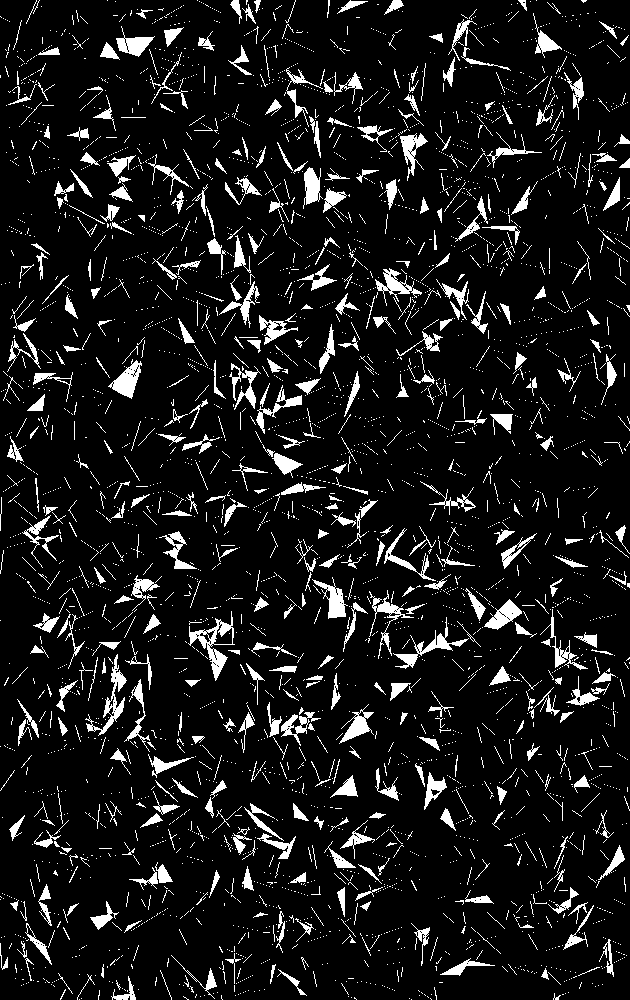

6575.5522
25307.238
6317.086
4612.288
2007.1024
963.8088
513.0323
505.70602
394.9916
318.7476
260.03665
178.1785
113.38872
134.5234
144.89543
275.11343
250.77435
538.306
696.9384
756.1778
225.05357
159.15878
203.56662
168.33926
117.73579
134.6519
127.83006
182.50822
120.519104
100.64245
97.790276
103.85521
146.3617
158.87486
234.35805
308.09473
427.74124
554.00214
741.3205
581.7774
682.62024
560.86316
577.1557
834.856
635.176
254.2745
268.12656
375.65695
355.22186
216.90434
178.81523
157.71625
176.44246
234.569
339.93286
357.366
423.4622
361.78278
306.82587
330.87576
269.29306
333.7963
301.7645
408.81223
593.17163
606.0362
557.7905
470.49213
432.78644
253.68127
241.56615
244.03731
278.6225
267.36652
205.13087
183.34503
223.6372
260.45236
346.1133
376.4531
328.03522
393.31873
546.69714
472.80545
485.9456
478.68878
542.4207
442.9292
396.93066
336.85727
267.13464
211.79474
188.26491
176.80473
172.81812
195.13739
208.31833
243.8071
230.4085
240.28671
Iteration: 100 loss: 2.382 s/iter: 1.24

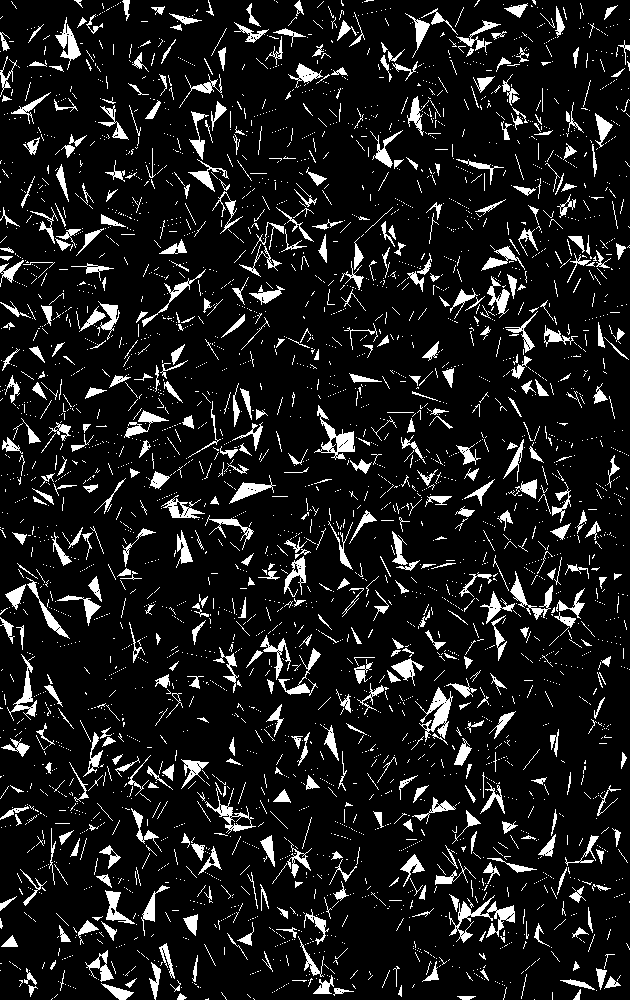

238.11919
332.02603
447.09253
491.22894
512.8119
926.068
2138.5508
1732.9236
1635.4304
998.3107
530.25244
411.62823
129.83313
76.64075
90.33802
110.13256
109.44469
88.239944
79.78452
98.95667
126.75047
144.39543
153.25269
155.10529
165.79326
235.01328
306.07
331.82288
268.15207
257.4331
235.13644
278.06552
299.89633
284.77472
311.07806
366.01685
452.07666
363.6787
419.06558
411.88965
667.4054
738.636
523.2386
536.51624
347.0749
398.00952
401.04974
292.68475
269.6271
235.19545
231.99876
202.03477
216.4315
179.709
175.80547
197.96521
220.33745
219.766
188.16322
187.13437
200.97578
203.7519
258.25742
345.8965
426.3592
460.41547
555.5041
417.35602
314.7047
423.84274
584.4021
490.37616
496.955
425.58185
383.7013
264.06125
214.37619
188.43698
179.1023
173.11859
132.75093
148.99846
179.65111
191.04361
208.26907
253.29578
305.3661
450.77185
628.03033
562.9679
586.7871
607.39606
535.9217
418.93713
385.9483
334.12094
243.31053
140.5914
129.1328
133.47206
Iteration: 200 loss: 1.373 s/iter: 1.251e

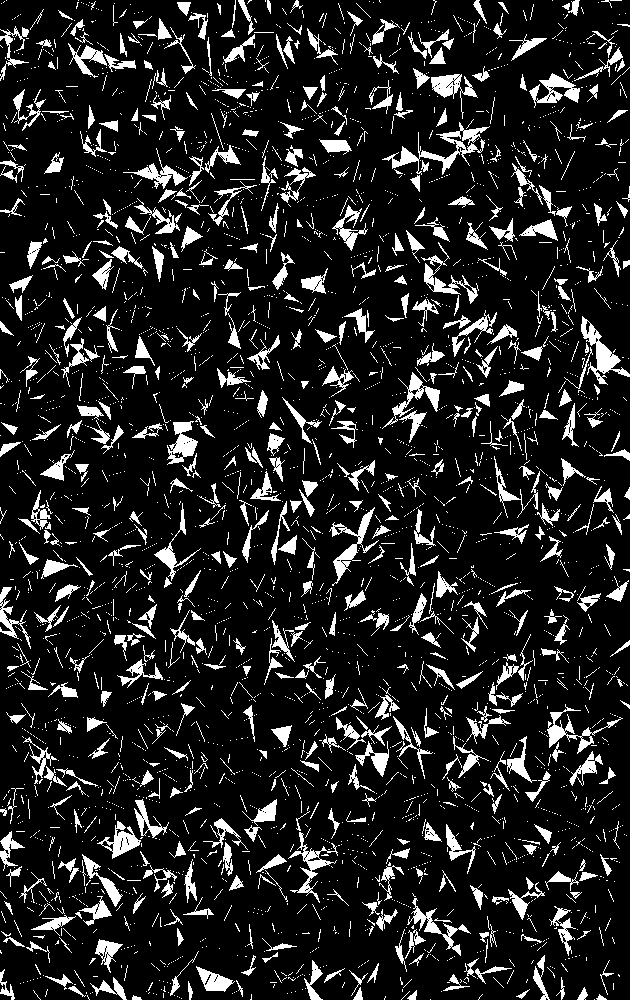

137.3344
148.62798
153.1531
156.47867
157.56706
180.26071
198.65578
238.87361
240.47102
231.56398
305.68362
392.34863
368.86276
331.93967
294.9184
323.42606
369.52573
427.26462
468.3572
467.45316
338.13275
289.30215
305.63586
236.54324
275.94766
317.61826
196.33374
151.79837
155.10072
250.44292
271.23868
233.58018
205.22737
223.38625
225.63977
264.5516
269.62305
280.0696
254.77936
259.12616
254.37334
279.9975
363.161
420.76804
422.90533
403.43494
339.30576
265.8426
263.7448
216.55049
229.96167
219.74522
226.50038
167.36357
137.22453
133.93622
135.80783
202.05713
329.43738
312.35626
286.33975
292.0105
302.537
478.80768
484.3684
385.23022
463.13974
335.5637
298.9376
273.3365
258.94974
272.2642
183.03207
130.79564
126.818115
153.56456
162.25874
191.69354
192.43176
154.03654
124.18858
135.60509
169.62575
228.36003
250.46834
261.2532
236.38908
173.45807
217.26181
230.90248
247.3549
213.56021
266.24048
332.5675
265.68423
298.65488
449.56702
501.97162
490.17694
269.24228
Iteration: 300 loss: 

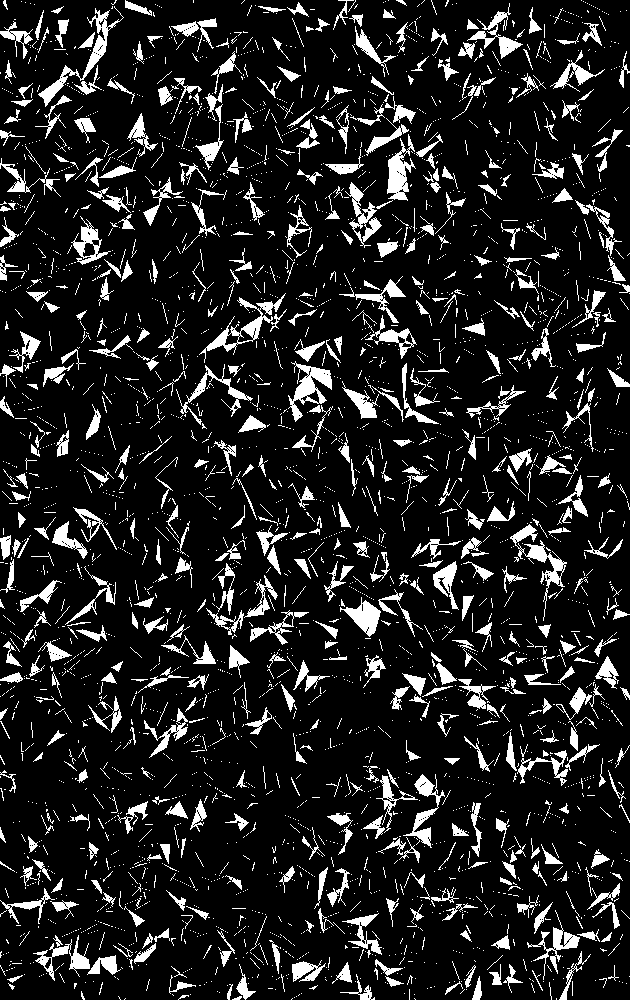

257.59128
180.00768
130.12733
126.089584
104.144684
85.71119
83.51956
130.08017
234.60623
275.58304
221.10944
200.28413
245.42114
280.67905
289.5865
264.20358
251.61537
231.77141
206.05164
201.35924
203.92583
187.26924
222.7534
150.9688
155.87566
132.05826
156.90369
189.26147
197.91985
210.91441
233.7822
261.5989
187.16647
195.31181
222.027
136.14078
205.1626
334.74924
349.76212
314.1661
239.96648
271.55554
213.45732
179.93689
263.76437
204.4476
178.88786
299.1897
242.23776
167.52567
139.21014
168.59026
158.92786
112.903206
120.88181
123.57094
154.90952
155.69487
148.43132
141.93414
146.21227
115.82655
108.46991
149.94884
199.38469
205.97462
184.22052
196.35878
184.0854
246.0939
269.69135
260.9967
212.74208
290.47232
375.20685
224.24326
174.06258
150.73434
107.744965
91.72899
91.41749
124.7795
129.38902
138.2501
156.46188
124.7467
142.52385
172.21399
184.59492
194.8224
184.6887
179.90367
156.24649
170.95143
123.34908
103.59424
136.32178
154.55351
160.77818
119.69424
Iteration: 400 loss

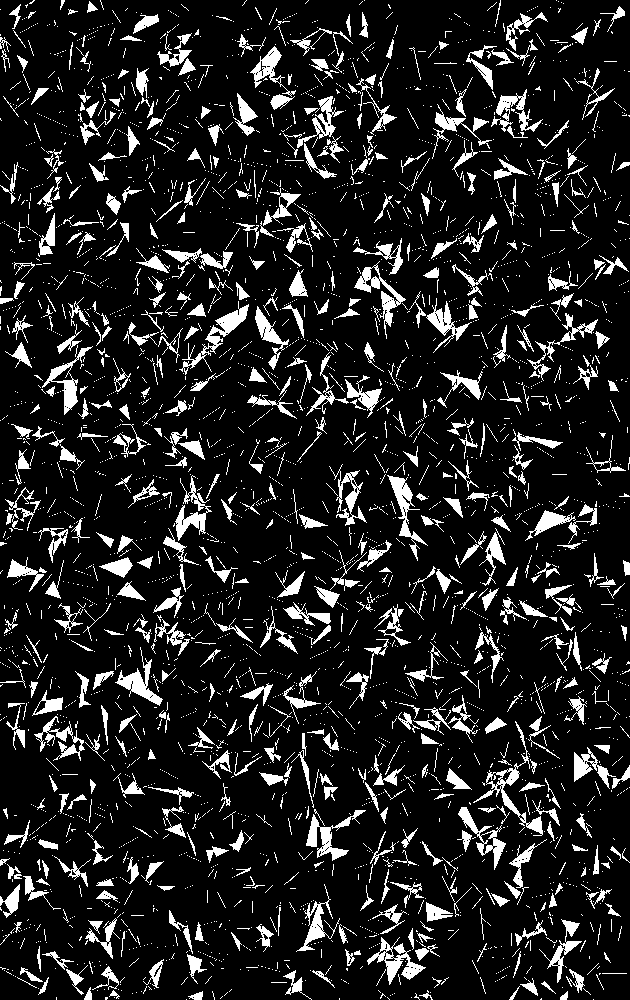

137.05836
212.57182
270.91522
231.2025
295.89478
427.37015
265.56445
333.84802
388.46463
252.65584
192.01108
144.39287
92.96481
50.338425
29.585476
17.767162
15.255069
28.743418
59.4865
69.02716
53.035576
79.695404
129.61795
149.97763
180.1986
207.95299
142.19492
131.82417
120.92289
142.83208
97.84127
99.6134
84.67045
90.6846
94.62438
124.40348
190.76703
162.84465
245.40717
228.46701
149.9666
195.85245
204.70193
176.4746
209.0573
178.38724
130.02507
126.51528
120.9852
87.543884
54.859055
54.577976
96.238106
68.70307
53.112377
56.646355
57.40631
54.35842
66.725945
76.85925
72.80239
75.31065
88.23931
77.10511
101.872246
122.06758
192.1547
175.40887
328.0124
224.78796
245.28374
188.22653
359.25992
175.23198
159.27046
120.589645
101.86737
83.10053
45.922646
25.050636
25.801653
29.904636
38.902924
58.317146
73.04482
51.532608
56.016876
81.913055
85.12172
89.70862
107.07712
114.863235
95.35149
74.11753
75.47362
89.535446
120.78587
86.50264
65.46467
74.24325
Iteration: 500 loss: 0.715 s/iter:

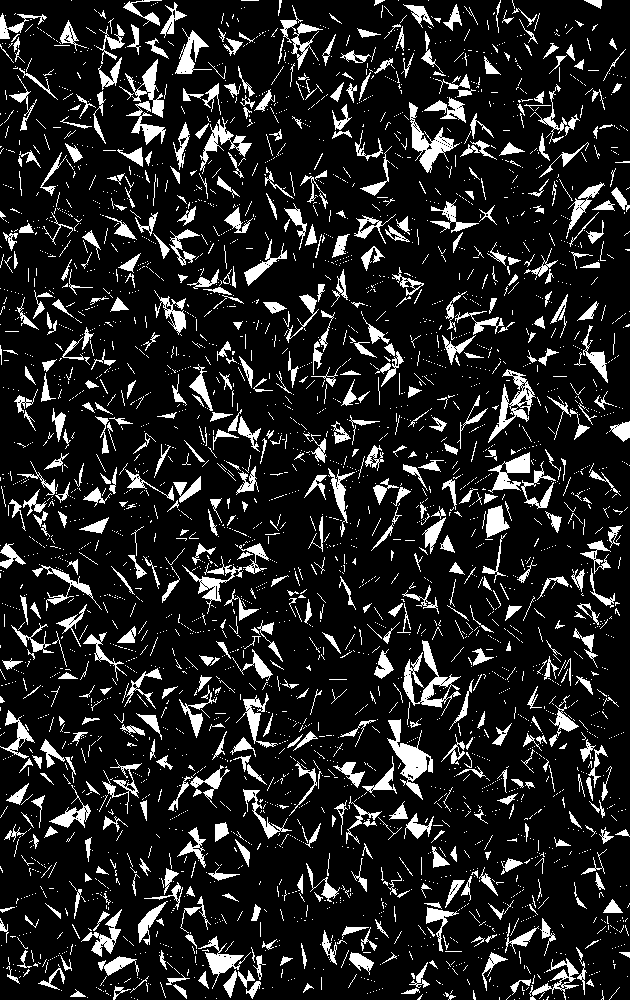

71.53715
90.60146
55.951416
65.51428
76.626144
91.1613
67.12769
57.585865
57.073708
67.96991
77.07465
54.28321
86.60207
108.16225
215.06895
193.2649
291.54996
381.91547
515.0468
664.8321
326.42194
416.44824
257.46732
164.55165
61.926758
17.75935
6.096867
3.6232924
2.720176
3.1693332
5.1074796
9.839713
17.88693
22.546392
18.287237
14.966173
20.211672
30.100935
41.094067
33.305122
35.85084
38.163315
32.68807
28.032846
27.617348
30.140322
57.904816
65.288994
72.18619
56.767887
88.26829
70.28978
78.52621
49.44399
41.582108
50.871525
29.509848
30.771454
47.401325
63.748013
94.761116
64.90857
145.5969
91.22403
160.76987
152.70515
195.67099
199.1138
264.56198
200.00417
236.75002
154.47311
153.65959
126.41943
81.1275
27.886938
8.456075
6.343597
8.324551
14.251243
18.788548
20.09633
26.882254
33.208954
25.819027
17.128773
9.563445
6.235124
5.0712466
6.8567295
9.5232935
13.186931
13.110321
14.779994
19.63356
33.262154
42.37408
38.46719
80.07668
38.525887
Iteration: 600 loss: 1.181 s/iter: 1.288e

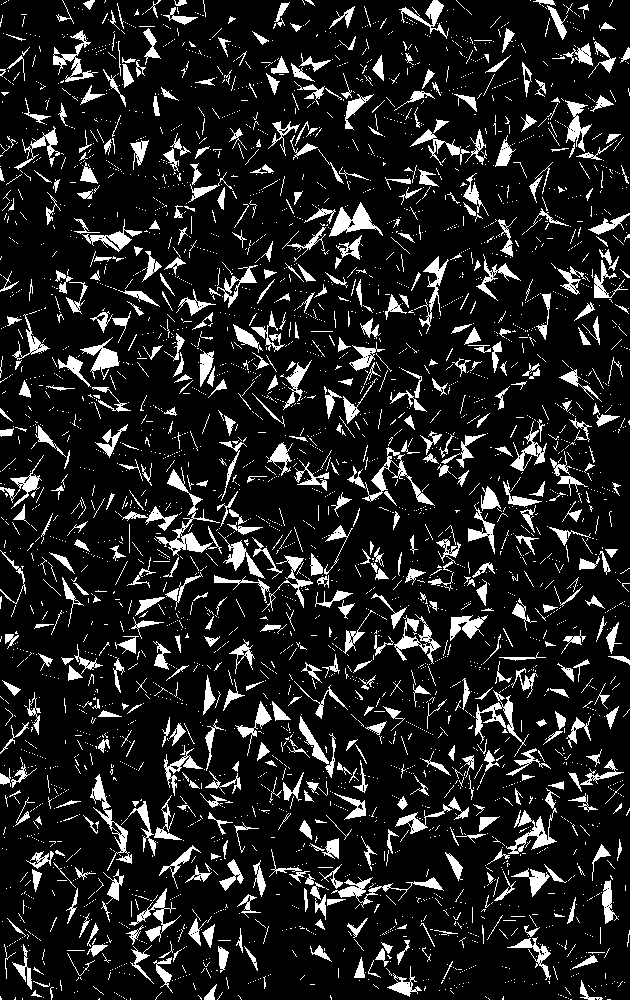

117.977615
74.39122
271.18146
213.84747
921.11456
984.9133
1523.392
1730.9376
1043.1798
372.3515
140.27412
18.324463
6.9751625
4.2427797
3.8107872
4.1685486
4.033075
5.013872
4.0262375
5.506253
5.9282684
13.459488
24.925226
56.35812
28.310694
21.689909
4.405176
3.3498251
4.0426474
8.443219
17.127632
26.925213
26.249088
18.555485
25.297136
29.85619
27.89906
20.907148
17.921099
19.75018
30.985228
37.585255
33.091106
21.87867
15.396054
19.378414
31.547802
35.663982
31.025263
26.363733
24.94534
17.68613
24.42039
28.241423
35.522953
31.267117
30.968393
27.727676
23.654787
22.028421
36.64594
35.519257
47.427567
43.569798
140.60689
72.197586
376.2705
212.4551
1522.1632
305.94492
3868.7642
296.2244
401.8842
331.75928
63.16073
27.183908
6.969078
3.8782914
2.6044393
2.0880315
1.9349251
2.0091655
2.4368002
3.1111493
5.245324
7.6698885
15.809209
17.142317
24.666487
8.239662
6.31104
5.065912
10.853842
22.16497
43.0614
28.91602
20.619596
20.996456
23.951456
15.590682
Iteration: 700 loss: 0.143 s/ite

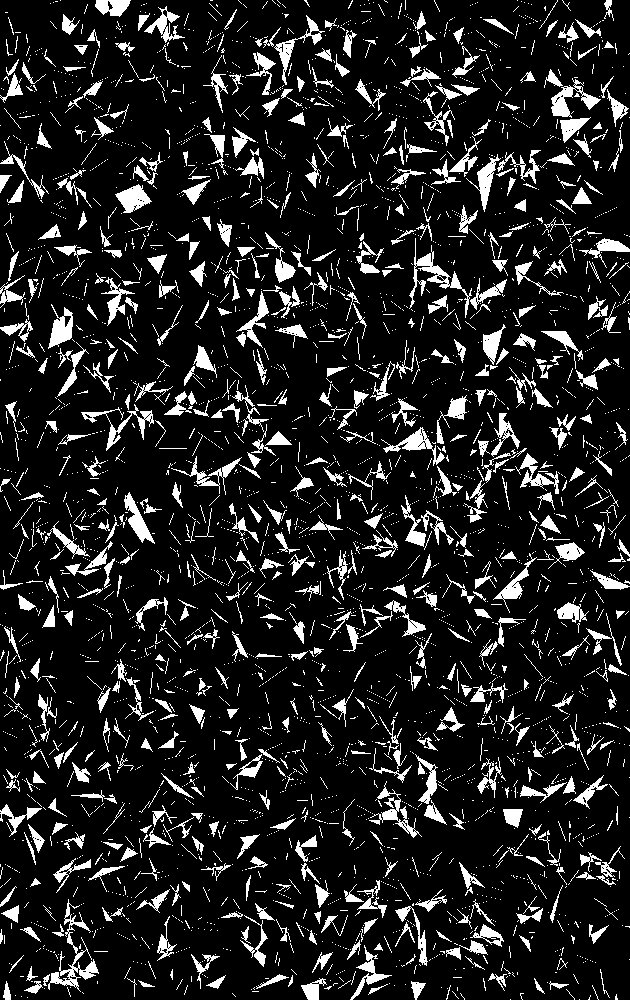

14.330369
19.603535
29.181118
30.468609
12.13303
8.676135
6.764555
9.5857935
13.511377
18.873827
19.707022
23.35679
21.60333
30.979843
35.40355
30.699282
38.606056
49.10419
44.16579
58.34985
92.435135
107.85535
88.68741
344.70493
135.02942
811.51196
190.3416
655.49097
99.19802
453.8994
208.18398
111.527336
58.113636
16.416391
5.3032775
3.273464
3.1968846
3.776087
5.3141985
7.1293488
10.051653
10.6515665
11.6946535
10.360646
11.164972
11.871276
14.18918
16.935087
19.981783
16.757051
11.699746
13.99644
16.785076
14.702347
8.45033
8.11359
9.093365
12.218779
13.795627
15.266466
11.776841
13.13262
16.13072
17.488653
19.518383
27.201038
21.87275
29.362955
15.344795
43.315895
19.517614
50.113102
68.70126
185.84207
150.50714
1324.7891
508.6799
3505.6313
1217.5509
1738.1455
538.5268
85.70843
19.444271
10.524598
7.2725034
6.060738
6.1879992
7.9138083
13.477092
22.436357
41.40426
32.65896
28.605413
12.1308565
6.574818
3.5754602
2.5210934
2.1544757
2.1069808
2.7388697
Iteration: 800 loss: 0.034 s/

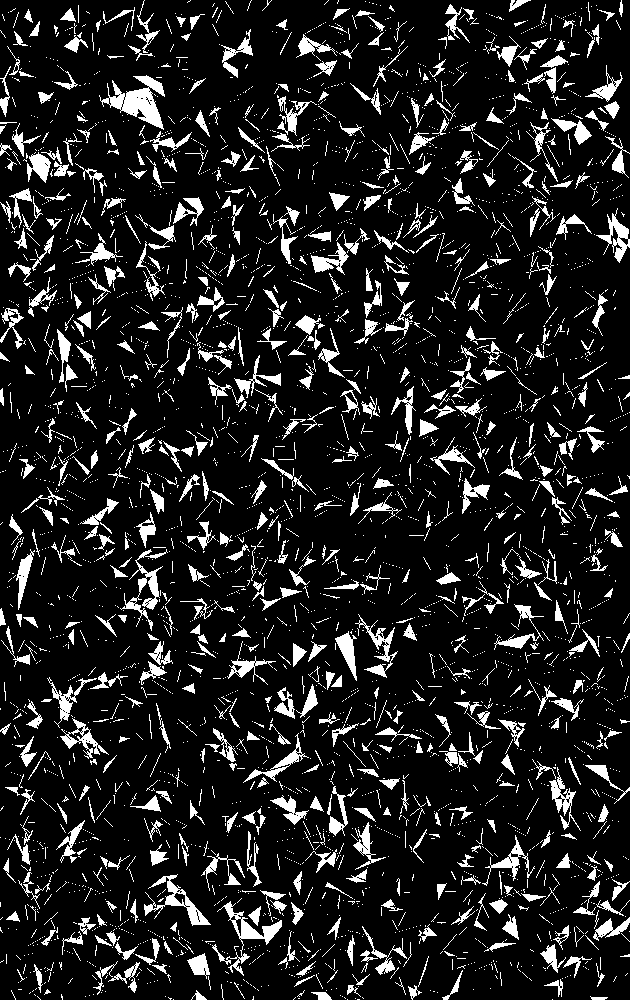

3.40973
5.4108276
7.861733
12.89942
16.948305
23.250486
23.041567
25.030624
17.892416
17.403252
21.172035
28.6384
41.87873
42.39758
36.56903
25.847652
16.214754
11.428157
13.496144
14.660912
12.54763
13.601882
14.762924
16.625767
12.5491295
11.9609375
10.227101
13.411318
15.242524
13.704327
15.625175
15.20765
9.881569
10.207169
14.201407
10.232416
11.658562
16.184544
24.443886
27.921064
64.680916
236.37599
298.75986
2920.0955
1498.187
3544.016
1204.9755
874.2148
548.9187
74.63227
23.712772
10.493512
5.7748084
3.9550781
3.0098991
2.4634147
2.114188
1.8748384
1.7288803
1.7612371
1.9046917
2.278507
2.8643415
3.1871378
3.7190473
4.6539226
9.526466
18.437078
36.798687
38.037716
41.840393
30.667953
26.00211
23.123667
28.449823
39.266846
36.712727
33.647377
25.56664
19.520424
12.291731
10.512144
8.930056
10.484404
12.089285
15.435435
16.233406
16.24216
12.608143
12.491278
16.077335
24.375336
25.034924
29.332024
41.815807
33.221714
31.055351
20.033573
17.995127
12.950729
Iteration: 900 loss: 0

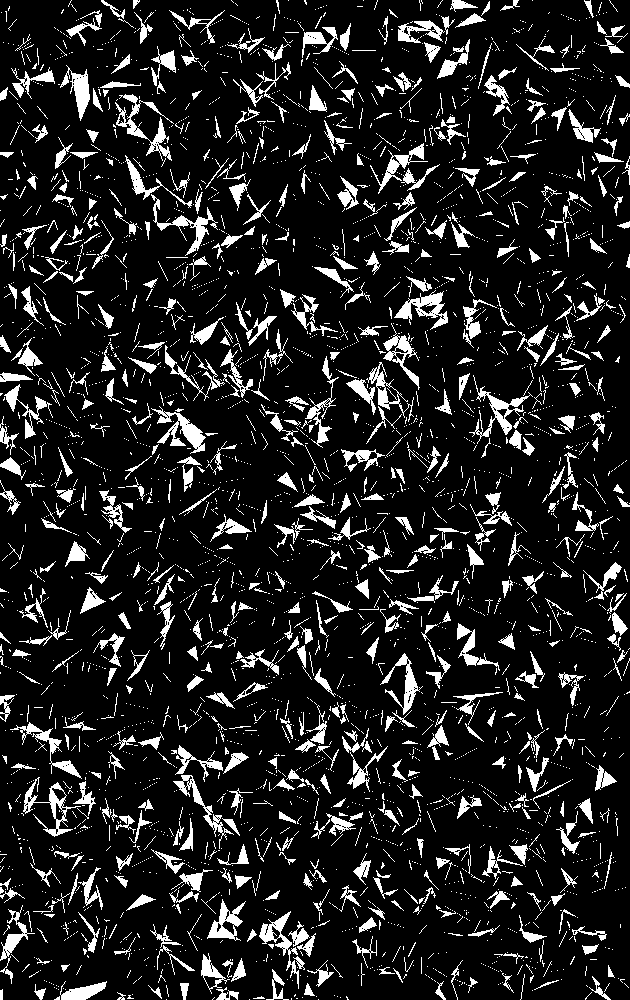

10.168083
11.439503
8.221451
5.764896
5.585692
6.445241
8.684234
8.999381
7.82949
6.313771
7.7671814
9.8179035
9.999522
12.595347
10.736907
11.659507
7.3785734
9.911239
12.930968
28.985577
44.553684
276.9262
680.7702
4647.183
3238.5876
2971.9104
1967.6122
272.1221
47.824574
16.849796
8.664892
5.874047
4.437043
3.5451534
2.865142
2.380654
2.0331955
1.8660662
2.1145372
3.5030985
9.306691
25.04616
61.833256
63.0414
66.916725
20.828545
9.938018
5.285813
4.029552
4.1643333
5.280093
8.469762
14.2532425
24.93373
36.66078
52.36958
45.918777
37.756012
25.640324
23.586254
28.222433
38.330845
43.960426
31.775724
18.070936
11.413854
9.376924
10.868357
15.675532
22.613264
27.683699
30.22545
33.503323
30.951435
29.13171
25.62053
19.186981
14.198532
10.183991
8.747215
7.280554
8.990415
14.779383
15.981441
13.120137
14.761665
21.086716
17.019135
14.1256695
13.646962
13.15015
15.549505
46.06009
27.90553
123.26674
108.71177
616.7774
377.64767
3009.8982


In [52]:
# Run training
with tf.Session() as sess:
  #print('Saving TensorBoard summaries and images to: %s' % FLAGS.logdir)
  #train_writer = tf.summary.FileWriter(FLAGS.logdir, sess.graph)

  t0 = time.time()
  for i in range(FLAGS.iterations):
    print(loss.eval())

    #sess.run([tf.add_check_numerics_ops(), train_op])
    sess.run(train_op)

    # Print progress and save samples every so often
    if i % FLAGS.print_every == 0:
      np_loss = sess.run(loss)
      #train_writer.add_summary(summary_str, i)
      print('Iteration: {0:d} loss: {1:.3f} s/iter: {2:.3e}'.format(
          i,
          np_loss / FLAGS.batch_size,
          (time.time() - t0) / FLAGS.print_every))
      t0 = time.time()

      # Save samples
#       np_posterior_samples, np_prior_samples = sess.run(
#           [posterior_predictive_samples, prior_predictive_samples])
      # for k in range(FLAGS.n_samples):
      display(drawOutlines(posterior_predictive_samples.eval(), cellsize=10, glyphCount=glyphNum))
      #display(drawOutlines(np_prior_samples, cellsize=30, glyphCount=glyphNum))
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_data.jpg' % (i, k))
      #imsave(f_name, np_x[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_sample.jpg' % (i, k))
      #imsave(f_name, np_posterior_samples[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_prior_predictive_%d.jpg' % (i, k))
      #imsave(f_name, np_prior_samples[k, :, :, 0])


In [0]:
      # Plot the posterior predictive space
      #     if FLAGS.latent_dim == 2:
      #       np_q_mu = sess.run(q_mu, {x: np_x_fixed})
      #       cmap = mpl.colors.ListedColormap(sns.color_palette("husl"))
      #       f, ax = plt.subplots(1, figsize=(6 * 1.1618, 6))
      #       im = ax.scatter(np_q_mu[:, 0], np_q_mu[:, 1], c=np.argmax(np_y, 1), cmap=cmap,
      #                       alpha=0.7)
      #       ax.set_xlabel('First dimension of sampled latent variable $z_1$')
      #       ax.set_ylabel('Second dimension of sampled latent variable mean $z_2$')
      #       ax.set_xlim([-10., 10.])
      #       ax.set_ylim([-10., 10.])
      #       f.colorbar(im, ax=ax, label='Digit class')
      #       plt.tight_layout()
      #       plt.savefig(os.path.join(FLAGS.logdir,
      #                                'posterior_predictive_map_frame_%d.png' % i))
      #       plt.close()

      #       nx = ny = 20
      #       x_values = np.linspace(-3, 3, nx)
      #       y_values = np.linspace(-3, 3, ny)
      #       canvas = np.empty((28 * ny, 28 * nx))
      #       for ii, yi in enumerate(x_values):
      #         for j, xi in enumerate(y_values):
      #           np_z = np.array([[xi, yi]])
      #           x_mean = sess.run(prior_predictive_inp_sample, {z_input: np_z})
      #           canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
      #                  28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
      #       imsave(os.path.join(FLAGS.logdir,
      #                           'prior_predictive_map_frame_%d.png' % i), canvas)
      # plt.figure(figsize=(8, 10))
      # Xi, Yi = np.meshgrid(x_values, y_values)
      # plt.imshow(canvas, origin="upper")
      # plt.tight_layout()
      # plt.savefig()
